In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pathlib
# Setup paths and make sure they are pathlib objects
paths = dict(
    field_loads="/proj/gallippilab/projects/batch_load_simulations/loads",
    dyna_sims="/proj/gallippilab/users/joeyr/dyna_examples",  
)
paths = {k: pathlib.Path(v) for k, v in paths.items()}
paths

{'field_loads': PosixPath('/proj/gallippilab/projects/batch_load_simulations/loads'),
 'dyna_sims': PosixPath('/proj/gallippilab/users/joeyr/dyna_examples')}

In [8]:
from fem.dyna.mesh import UniformCoordinates, UniformMesh
from fem.dyna.material import KelvinMaxwellViscoelastic


# Imaging configuration
txer = "9l4"
att = 0.5
fnum = 1.5
fd = 30

# VisR load configuration
load_curve_id = 1
normalization_isppa = 2000
t_arf = 70e-6
dt = 1e-6
n_arf = 2
tracks_between = 6
prf = 10e3
multipush_params_list = [t_arf, dt, n_arf, tracks_between, prf]

material = KelvinMaxwellViscoelastic(density=1, E=13 * 1e3, nu=0.499, eta=0.01)

# Create mesh
coords = UniformCoordinates(
    grid_size=400,  # microns
    xmin=-1.0,
    xmax=0.0,  # ele
    ymin=0.0,
    ymax=1.0,  # lat
    zmin=-4.0,
    zmax=0.0,  # ax
)
symmetry = "q"
mesh = UniformMesh(coords, symmetry, material)

# Add pml to mesh
mesh.add_pml(pml_thickness=7, exclude_faces=["zmax"])

# Constrain boundary nodes (do this after adding structures and PML)
mesh.constrain_boundary_nodes()

# Set total simulation time and time step to save results
mesh.set_control(end_time=8e-3)
mesh.set_database(dt=0.5e-4)

# Add load to mesh from pregenerated field loads
if fd < 25:
    load_name = f"txer=l94_row1,fd=[0,0,{fd}],fnum={fnum},att={att}"
else:
    load_name = f"txer=l94_row3,fd=[0,0,{fd}],fnum={fnum},att={att}"

field_load_file = paths["field_loads"] / f"{load_name}.mat"
mesh.add_load_curve(load_curve_id, "multipush", multipush_params_list)
mesh.add_field_arf_load(field_load_file, normalization_isppa, load_curve_id)

# Write dyna cards and create simulation folder structure
sims_path = paths["dyna_sims"] / 'test'
material_folder_name = (
    f"e={mesh.materials[0]['material'].E/1e3:.0f},v={mesh.materials[0]['material'].eta}"
)
str(mesh.material)
load_folder_name = load_name
mesh.write_all_dyna_cards(sims_path, load_folder_name, material_folder_name)

In [2]:
from fem.dyna.material import TransverselyIsotropicElastic
opts = {
    # Values in 'bar' = Pa * 10
    "EL": 440400,
    # Values in 'bar' = Pa * 10
    "ET": 146800,
    # Values in 'bar' = Pa * 10
    "muL": 120000,
    # Values in 'bar' = Pa * 10
    # "muT": 20000,
    "density": 1,
    "rotation_angle": 0,
    "tilt_angle": 0,
}

# TransverselyIsotropicElastic(**opts)
mat = TransverselyIsotropicElastic(**opts)
mat
# print(mat)
print(mat.format_material_card(1))
print(mat.format_pml_card(1))

*MAT_ORTHOTROPIC_ELASTIC
$ C is the stiff (or AOS) direction
$ MID, DENSITY, Ea, Eb, Ec, PRba, PRca, PRcb
1,1,146800,146800,440400,0.83333333,0.499,0.499
$ Gab, Gbc, Gca, AOPT, g, sigf
4.00364E+4,120000,120000,2.0,0.0,0.0
$ c=axd is an angle 0 with y-axis
$ XP, YP, ZP, a1, a2, a3, MACF
0.0,0.0,0.0,1.0,0.0,0.0,1.0
$ v1, v2, v3, d1, d2, d3, beta, ref
0.0,0.0,0.0,0,0,1,0.0,0.0

*MAT_PML_ORTHOTROPIC_ELASTIC
$ C is the stiff (or AOS) direction
$ MID, DENSITY, Ea, Eb, Ec, PRba, PRca, PRcb
1,1,146800,146800,440400,0.83333333,0.499,0.499
$ Gab, Gbc, Gca, AOPT, g, sigf
4.00364E+4,120000,120000,2.0,0.0,0.0
$ c=axd is an angle 0 with y-axis
$ XP, YP, ZP, a1, a2, a3, MACF
0.0,0.0,0.0,1.0,0.0,0.0,1.0
$ v1, v2, v3, d1, d2, d3, beta, ref
0.0,0.0,0.0,0,0,1,0.0,0.0



In [4]:
from scipy.io import loadmat

p = pathlib.Path(
    "/proj/gallippilab/users/joeyr/dyna_examples/ti_material/txer=l94_row3,fd=[0,0,30],fnum=1.5,att=0.5/rot=0,tilt=0,EL=440400,ET=146800,muL=120000/res_sim.mat"
)

mat = loadmat(p)
print(mat.keys())
print(mat["arfidata"].shape)
print(mat["axial"].shape)
print(mat["lat"].shape)
print(mat["ele"].shape)
print(mat["t"].shape)

dict_keys(['__header__', '__version__', '__globals__', 'arfidata', 'axial', 'lat', 'ele', 't'])
(259, 59, 59, 161)
(1, 259)
(1, 59)
(1, 59)
(1, 161)


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

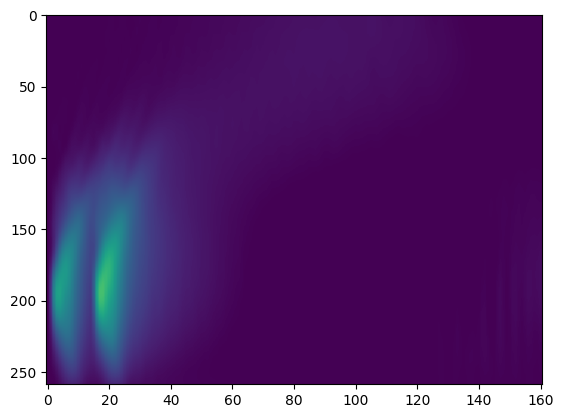

In [7]:
plt.imshow(mat["arfidata"][:,0,-1,:], aspect="auto", vmin=0, vmax=5)

In [8]:
import numpy as np
focal_depth = 30
ax_idx = np.argmin(np.abs(mat['axial'] - focal_depth))
t_idx = 10
plt.imshow(mat["arfidata"][ax_idx, :, :, t_idx], aspect="auto", vmin=0, vmax=5)

199
